In [1]:
import os
import pandas as pd
HOUSING_PATH = os.path.join("datasets", "housing")
housing = pd.read_csv(os.path.join(HOUSING_PATH, "housing.csv"))

In [2]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=[1,2,3,4,5])

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2,random_state=42) 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #n_splitsは分割の回数
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set= housing.loc[test_index]

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [6]:
X = imputer.transform(housing_num)
housing_train = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


In [7]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [8]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

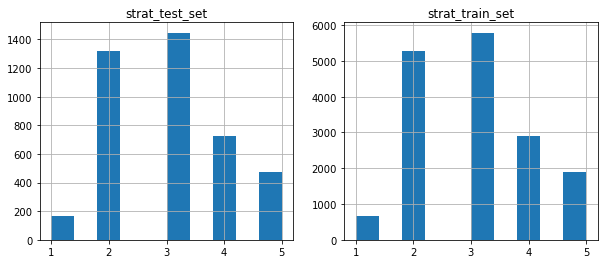

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


strat_test_set["income_cat"].hist(ax=ax1)
ax1.set_title("strat_test_set")


strat_train_set["income_cat"].hist(ax=ax2)
ax2.set_title("strat_train_set")

plt.show()
for set_ in (strat_train_set, strat_test_set): #set_を使ってstrat_train_setとstrat_test_setを一行ずつ取り出す
    set_.drop("income_cat", axis=1, inplace=True)#axis=1は列方向を指定するためのオプション
                                                  #inplace=Trueは削除操作を元のデータセットに直接適用するためのオプション
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

In [10]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6 #それぞれの列番号に対応している、下では列番号を呼び出すことで利用する。

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): #BaseEstimatorとTransformerMixinを継承しています。これにより、get_params()やset_params()などのメソッドを継承することができます。
    def __init__(self, add_bedrooms_per_room = True):  #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix] #X の中で、population_ix 列と households_ix 列を要素ごとに割った結果を計算しています。
        if self.add_bedrooms_per_room: #add_bedrooms_per_roomがTrueの時に実行されます
            bedrooms_per_room = X[:,bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]#np.c_はNumPyの関数であり、
                                                                                             #  与えられた配列を列方向に結合するため
                                                                                     #  に使用されます。c_は"concatenate"（連結）を表す略語です。
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs =attr_adder.transform(housing.values)#housing.valuesはhousingの値をNumPy配列として表現したもの

In [12]:
housing_extra_attribs
housing_e = pd.DataFrame(housing_extra_attribs)
housing_e

,0,1,2,3,4,5,6,7,8,9,10
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,6.658342,2.023976
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,5.571932,3.363188
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,4.110465,2.662791
16510,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,6.297405,2.411178


In [13]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [14]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2


In [15]:
housing_num = housing_num.drop("income_cat", axis=1)
housing_num = housing_num.drop("median_house_value", axis=1)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [17]:
list(housing_num)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [18]:
list(housing)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [19]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"] #cat_attribsはカテゴリーの変数、つまり列の名字を代入している

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [20]:
pd.DataFrame(housing_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,0.466353,-0.092580,-0.443846,1.0,0.0,0.0,0.0,0.0
16508,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.050362,0.023024,-0.516065,0.0,1.0,0.0,0.0,0.0
16509,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,-0.509240,-0.037436,0.322869,1.0,0.0,0.0,0.0,0.0
16510,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,0.328149,-0.059156,-0.457023,1.0,0.0,0.0,0.0,0.0


In [21]:
from sklearn.svm import LinearSVC



svm_clf = LinearSVC(C=0.5, loss="hinge")
svm_clf.fit(housing_prepared,housing_labels)



F:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, loss='hinge')

In [22]:
from sklearn.metrics import mean_squared_error


some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)

print("Predictions:", svm_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [402600. 375900. 145200. 137500. 120700.]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [23]:
y_pred_test = svm_clf.predict(full_pipeline.transform(housing_test))
mse = mean_squared_error(housing_test_labels , y_pred_test)
mse

20020052615.021317

In [24]:
print("Predictions:", svm_clf.predict(full_pipeline.transform(housing_test))[:20])
print("Labels:", list(housing_test_labels)[:20])

Predictions: [500001. 120700. 167100. 145200. 145200. 211800. 137500. 500001. 175500.
 375900. 217200. 145200. 120700. 402600. 120700. 145200. 137500. 145200.
 402600. 402600.]
Labels: [500001.0, 162500.0, 204600.0, 159700.0, 184000.0, 151900.0, 104900.0, 500001.0, 367400.0, 346500.0, 337000.0, 59200.0, 212500.0, 274600.0, 227100.0, 115800.0, 97600.0, 85500.0, 337400.0, 366200.0]


In [25]:
rmse = np.sqrt(mse)
rmse
# quite close but the answer in RE may be better

141492.2351757202